In [1]:
import os
import pathlib
import keras
import numpy as np
import tensorflow as tf

In [2]:
root_dir = pathlib.Path('../data/Aksara-Bali')

In [3]:
def CreateDataset(data_dir, type=None):
    data_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        label_mode='categorical',
        color_mode='rgb',
        batch_size=32,
        image_size=(150, 150),
        seed=123,
        validation_split=0.2,
        subset=type
    )
    
    return data_ds

train_ds = CreateDataset(root_dir, 'training')
valid_ds = CreateDataset(root_dir, 'validation')

Found 15960 files belonging to 28 classes.
Using 12768 files for training.
Found 15960 files belonging to 28 classes.
Using 3192 files for validation.


In [4]:
class_names = train_ds.class_names
print('Class Names:\n {}'.format(class_names))

Class Names:
 ['Ba', 'Ca', 'Da', 'Ga', 'Ha', 'Ja', 'Ka', 'La', 'Ma', 'Na', 'Nga', 'Nya', 'Pa', 'Pengangge suara - Pepet', 'Pengangge suara - Suku', 'Pengangge suara - Taleng', 'Pengangge suara - Taleng Tedong', 'Pengangge suara - Tedong', 'Pengangge suara - Ulu', 'Pengangge tengenan - Adeg Adeg', 'Pengangge tengenan - Bisah (h)', 'Pengangge tengenan - Cecek (ng)', 'Pengangge tengenan - Surang (r)', 'Ra', 'Sa', 'Ta', 'Wa', 'Ya']


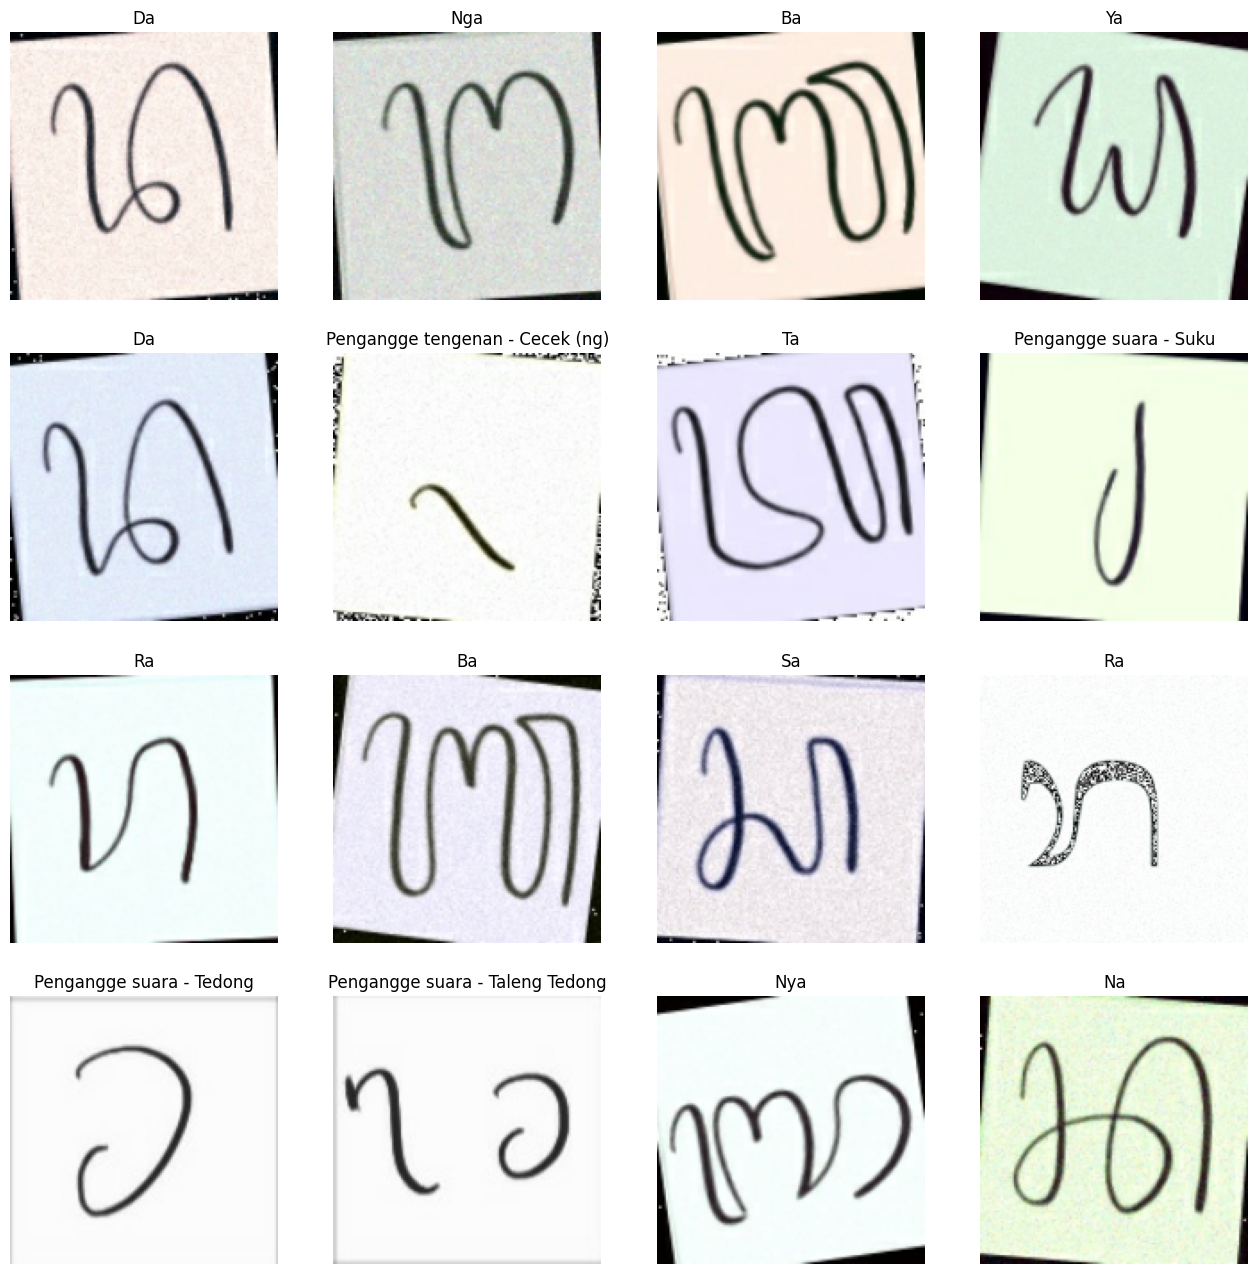

In [5]:
import matplotlib.pyplot as plt

def PlotDataset(dataset, class_list):
    plt.figure(figsize=(16, 16))
    for images, labels in dataset.take(1):
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            class_index = np.argmax(labels[i])
            plt.title(class_list[class_index])
            plt.axis('off')

PlotDataset(train_ds, class_names)

In [6]:
for image_batch, labels_batch in train_ds:
  print('Batch Image Shape:', image_batch.shape)
  print('Batch Labels Shape:', labels_batch.shape)
  break

Batch Image Shape: (32, 150, 150, 3)
Batch Labels Shape: (32, 28)


In [ ]:
# DON'T RUN THIS IF USING TRANSFER LEARNING

RESCALE = tf.keras.models.Sequential([keras.layers.Rescaling(1./255.)])

train_ds = train_ds.map(lambda x, y: (RESCALE(x), y))
valid_ds = valid_ds.map(lambda x, y: (RESCALE(x), y))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))

model = tf.keras.models.Sequential([
    inputs, 
    # tf.keras.layers.Rescaling(1./255.),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(700, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(560, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(28, activation='softmax', name='classification_layers')
])

model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy')>0.995 and logs.get('accuracy')>0.995:
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5), callbacks]
)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
MODEL_SAVE_PATH = '../models/model_bali_v5.h5'
tf.saved_model.save(model, MODEL_SAVE_PATH)

In [9]:
def save_my_model(model, history, type=None):
    accuracy = history.history['accuracy'][-1] * 1000
    val_accuracy = history.history['val_accuracy'][-1] * 1000
    
    model.save(f'../models/model_bali_{type}_{int(accuracy)}_{int(val_accuracy)}.h5')

In [ ]:
save_my_model(model, history, type='conv')

# Using Transfer Learning

In [20]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(150, 150, 3))

model = tf.keras.models.Sequential([
    inputs,
    base_model,
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(840, activation='relu'),
    tf.keras.layers.Dense(560, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(28, activation='softmax')
], name='Balinese_Script')

model.summary()

Model: "Balinese_Script"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 5, 5, 1280)        5919312   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32000)             0         
                                                                 
 dense_4 (Dense)             (None, 560)               17920560  
                                                                 
 dropout_2 (Dropout)         (None, 560)               0         
                                                                 
 dense_5 (Dense)             (None, 28)                15708     
                                                                 
Total params: 23855580 (91.00 MB)
Trainable params: 17936268 (68.42 MB)
Non-trainable params: 5919312 (22.58 MB)
____

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    verbose=1,
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3), callbacks]
    callbacks=callbacks
)

Epoch 1/50
399/399 [==============================] - 160s 380ms/step - loss: 0.5260 - accuracy: 0.8694 - val_loss: 0.0780 - val_accuracy: 0.9746
Epoch 2/50
399/399 [==============================] - 155s 388ms/step - loss: 0.0845 - accuracy: 0.9721 - val_loss: 0.0414 - val_accuracy: 0.9862
Epoch 3/50
399/399 [==============================] - 155s 388ms/step - loss: 0.0411 - accuracy: 0.9869 - val_loss: 0.0345 - val_accuracy: 0.9890
Epoch 4/50
399/399 [==============================] - 155s 389ms/step - loss: 0.0586 - accuracy: 0.9810 - val_loss: 0.0390 - val_accuracy: 0.9865
Epoch 5/50
399/399 [==============================] - 159s 398ms/step - loss: 0.0548 - accuracy: 0.9836 - val_loss: 0.0366 - val_accuracy: 0.9887
Epoch 6/50
399/399 [==============================] - 180s 451ms/step - loss: 0.0461 - accuracy: 0.9846 - val_loss: 0.0275 - val_accuracy: 0.9897
Epoch 7/50
399/399 [==============================] - 158s 396ms/step - loss: 0.0496 - accuracy: 0.9843 - val_loss: 0.0312 -

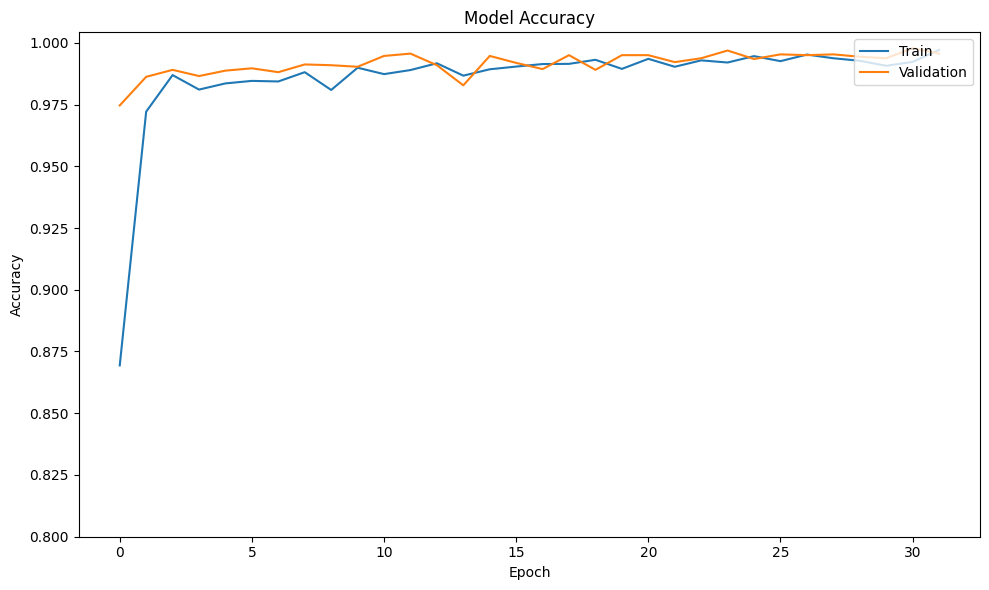

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.ylim(bottom=0.80)
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [24]:
save_my_model(model, history, type='efficientnet_v2')